# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report
from datetime import datetime

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.feature_selection import SelectKBest, f_classif

## Загрузка данных и первичный анализ

In [13]:
df_path = 'https://code.s3.yandex.net/datasets/autos.csv'

In [14]:
try:
    df = pd.read_csv(df_path)
except:
    print('Проверьте путь к датасету')

In [15]:
def primary_information(df):
    """Вывод общей информации о датасете"""
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [34]:
def pass_value_barh(df):
    """Вывод графика с количеством пропущенных значений"""
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Процент пропущенных значений' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('Пропусков нет')

In [84]:
def unique_values_table(df):
    """Вывод таблицы с количеством уникальных значений"""
    return df.nunique().sort_values(ascending=False)

Выведем общую информацию о датасете

In [4]:
primary_information(df)

Размерность: (354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим датасет наналичие пропущенных значений

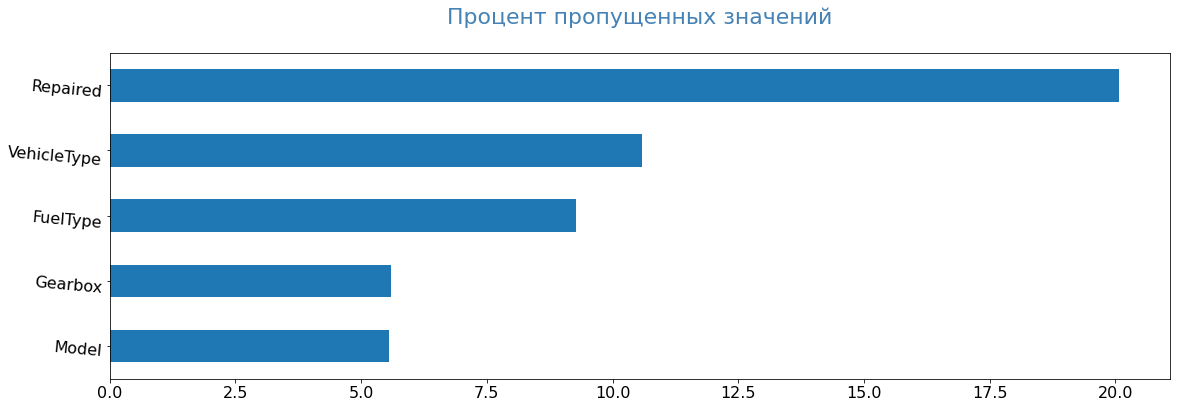

In [35]:
pass_value_barh(df)

Проверим датасет на наличие дубликатов

In [39]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Посмотрим количество уникальных значений в каждом поле

In [85]:
unique_values_table(df)

DateCrawled          271174
LastSeen             179150
PostalCode             8143
Price                  3731
Power                   712
Model                   250
RegistrationYear        151
DateCreated             109
Brand                    40
Kilometer                13
RegistrationMonth        13
VehicleType               8
FuelType                  7
Gearbox                   2
Repaired                  2
NumberOfPictures          1
dtype: int64

In [103]:
df['LastSeen'].unique()

array(['2016-04-07T03:16:57.000000000', '2016-04-07T01:46:50.000000000',
       '2016-04-05T12:47:46.000000000', ...,
       '2016-03-19T20:44:43.000000000', '2016-03-29T10:17:23.000000000',
       '2016-03-21T10:42:49.000000000'], dtype='datetime64[ns]')

In [110]:
df['lifetime'] = (datetime.today() - df['DateCreated']).dt.days

<AxesSubplot:>

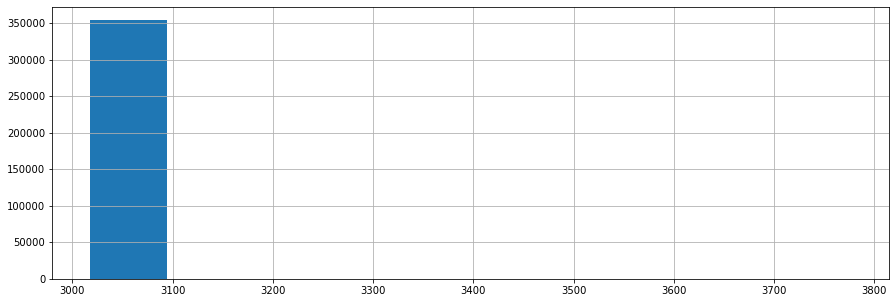

In [111]:
df['lifetime'].hist(figsize = (15,5))

### Промежуточный вывод
Был успешно выгружен датасет, содержащий более 350'000 строк и 16 признаков:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)

Первичный анализ показал, что датасет:
- имеет пропущенные значения в следующих полях:
    - `VehicleType`
    - `Gearbox`
    - `Model`
    - `FuelType`
    - `Repaired`
- содержит 4 полных дубликата
- содержит неинформативный признак `NumberOfPictures` с единственным уникальным значением

## Предобработка данных

Приведем даты к типу datetime

In [95]:
df['DateCrawled'] = pd.to_datetime(
    df['DateCrawled'], format="%Y-%m-%d"
)
df['DateCreated'] = pd.to_datetime(
    df['DateCreated'], format="%Y-%m-%d"
)
df['LastSeen'] = pd.to_datetime(
    df['LastSeen'], format="%Y-%m-%d"
)

Удалим дубликаты

In [8]:
df.drop_duplicates(ignore_index=True, inplace=True)

/home/iuser24/anaconda3/lib/python3.8/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable NumberOfPictures for analysis 1. Dropping this column
  warnings.warn(


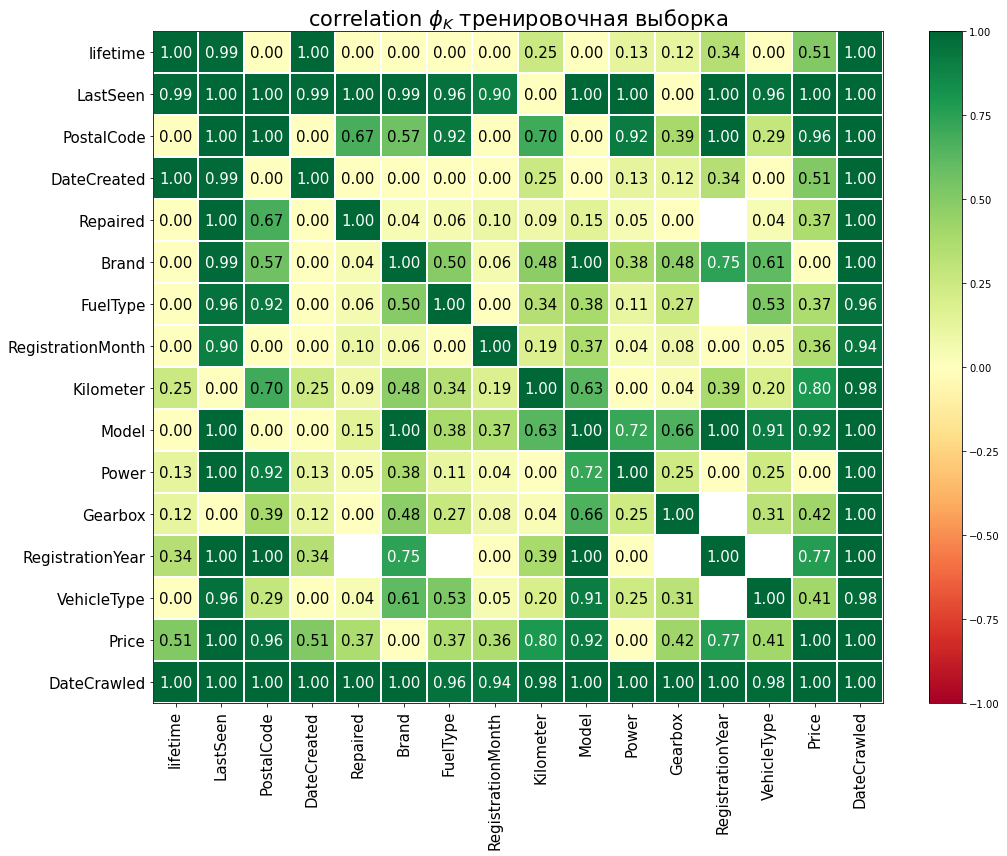

In [112]:
phik_overview = df.sample(1000).phik_matrix(
    interval_cols=['Power',  'RegistrationYear', 'Kilometer', 'RegistrationMonth']
)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тренировочная выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

In [9]:
def draw_boxplots(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

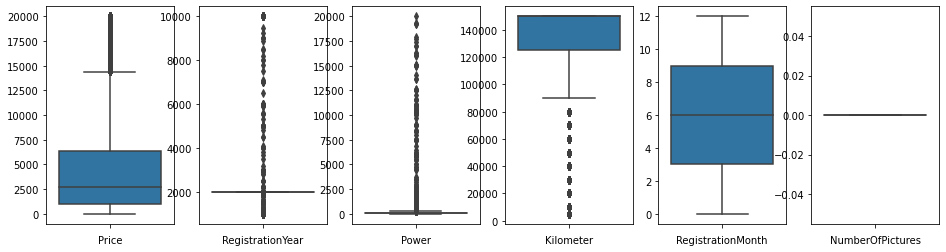

In [10]:
draw_boxplots(df, ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures'], "")

Удалим строки с аномальными значениями в поле `RegistrationYear` и `Power`

In [11]:
df.drop(df[(df['RegistrationYear'] > 2024) | (df['RegistrationYear'] < 1950)].index, inplace = True)
df.drop(df[(df['Power'] > 1500)].index, inplace = True)

In [13]:
def show_pie(df, columns, column_titles, main_title):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharey=True, figsize=(18, 6))
    if len(columns) == 1:
        (
            df[columns[0]].value_counts().plot.pie(autopct='%1.f%%', legend=False,
                wedgeprops = {"edgecolor" : "white", 
                              'linewidth': 2, 
                              'antialiased': True})
        )
        axes.title.set_text(column_titles[0])
    else:
        idx = 0
        for column in columns:    
            (
                df[column].value_counts().plot.pie(ax=axes[idx], autopct='%1.f%%', legend=False,
                    wedgeprops = {"edgecolor" : "white", 
                                  'linewidth': 2, 
                                  'antialiased': True})
            )
            axes[idx].title.set_text(column_titles[idx])
            idx+=1
    fig.suptitle(main_title, fontsize=30)

Пропусков в категориальных переменных довольно много, поэтому пропущенные значения заполним значеним `unknown` кроме ключевого параметра `Model`, строки с пропущенным значением в этом поле лучше удалить

In [14]:
df = df.dropna(subset = ['Model'])
df.fillna(value='other', inplace=True)
# df = df.dropna()

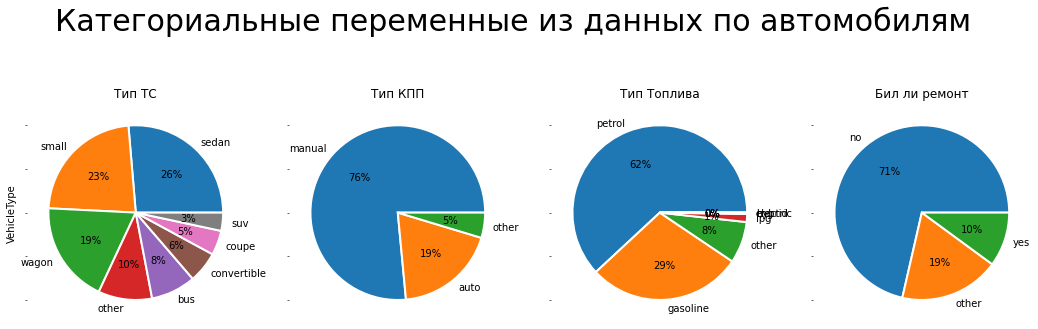

In [15]:
show_pie(
    df, 
    ['VehicleType', 'Gearbox', 'FuelType', 'Repaired'], 
    ['Тип ТС', 'Тип КПП', 'Тип Топлива', 'Был ли ремонт'],
    'Категориальные переменные из данных по автомобилям'
)

In [16]:
# df['vehicle'] = df['Brand'] + df['Model']
# df = df.drop(['Brand', 'Model'], axis=1)

# создаём список с наименованиями непрерывных признаков
interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тестовая выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

## Обучение моделей

In [17]:
import datetime as dt
# df['DateCreated']=df['DateCreated'].map(dt.datetime.toordinal)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other,70435
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
354359,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624
354360,0,other,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2694
354362,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135
354363,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,87439


In [18]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
X = df.drop(['Price', 'PostalCode', 'RegistrationMonth'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)
ohe_columns = ['Model', 'Brand', 'Gearbox', 'FuelType', 'VehicleType', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])
pipe_final.fit(X_train, y_train)
linreg_predictions = pipe_final.predict(X_test)

linreg_rmse = mean_squared_error(y_test, linreg_predictions, squared=False)
print(f"RMSE модели линейной регрессии: {linreg_rmse}")

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей